In [1]:
import glob
import pandas as pd
import pybedtools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools

In [1]:
#group_name = 'CA3_Glut'

In [3]:
ct = group_name
res = 25000
ddir = f'/data/female-amb/Diff.Result/CellType.Age.Diff.Domain/{ct}'
_dir = '/home/qzeng_salk_edu/project'
_min = 2e-308

In [4]:
binall = pd.read_csv(f'{_dir}/binall.csv',  index_col =0)
binall.columns = ['chrom', 'start','end']

In [5]:
all_diff_domain = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/ALL.Diff.Domain.csv', index_col = 0)
ct_diff_domain = all_diff_domain[all_diff_domain['celltype'] == ct]
ct_diff_domain =  ct_diff_domain[(ct_diff_domain['18mo-8wk'] > 0.05)]
ct_diff_domain = pd.concat([ct_diff_domain, binall], axis = 1).dropna()
ct_diff_domain = ct_diff_domain[[ 'chrom', 'start', 'end','8wk', '9mo', '18mo', '18mo-8wk', 'celltype']]
ct_diff_domain.head()

,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
chr1_2080,chr1,52000000,52025000,0.047970,0.051661,0.154982,0.107011,CA3_Glut
chr1_2644,chr1,66100000,66125000,0.147601,0.136531,0.287823,0.140221,CA3_Glut
chr1_2931,chr1,73275000,73300000,0.040590,0.066421,0.125461,0.084871,CA3_Glut
chr1_3482,chr1,87050000,87075000,0.059041,0.077491,0.151292,0.092251,CA3_Glut
chr1_3498,chr1,87450000,87475000,0.092251,0.162362,0.214022,0.121771,CA3_Glut


In [6]:
print(f"{ct_diff_domain.shape[0]} diff domain boundary")

131 diff domain boundary


## get TAD range

In [7]:
leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
ddir = f'/data/female-amb/Diff.Result/hicluster_bulk_domain/'

In [8]:
# bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
# cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
# bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
# bound_prob_ct= bound_prob_ct.T
# bound_prob_ct.head()

In [9]:
def find_nearest_domain(reference_index, df):
    cutoff= 0
    pos = df.index.get_loc(diff_domain)
    tmp = df[f"{ct}.8wk"]
    before = tmp.iloc[:pos][tmp.iloc[:pos] > cutoff]
    after = tmp.iloc[pos + 1:][tmp.iloc[pos + 1:] > cutoff]
    
    nearest_before = before.index[-1] if not before.empty else None
    nearest_after = after.index[0] if not after.empty else None
    return nearest_before, nearest_after

In [10]:
import anndata
adata = anndata.read_h5ad(f"{ddir}/{ct}.boundary.h5ad")
adata.var_names = adata.var.chrom.astype(str) + '_' + (adata.var.start // res).astype(str)

In [11]:
df = pd.DataFrame(adata.X.toarray().T, index = adata.var_names, columns = adata.obs_names)

In [12]:
all_tad_start = []
all_tad_end = []

for diff_domain in ct_diff_domain.index:
    nearest_before, nearest_after = find_nearest_domain(diff_domain, df)
    nerest_tad_start = int(nearest_before.split('_')[-1])* res
    nerest_tad_end = int(nearest_after.split('_')[-1])* res + res

    all_tad_start.append(nerest_tad_start)
    all_tad_end.append(nerest_tad_end)

In [13]:
#slop = 500000
ct_diff_domain['tad_start'] = all_tad_start
ct_diff_domain['tad_end'] = all_tad_end

## inersect with gene

In [14]:
ct_diff_domain = ct_diff_domain[['chrom', 'tad_start', 'tad_end', '8wk', '9mo', '18mo', '18mo-8wk', 'celltype', 'start', 'end',]]

In [15]:
genes = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/mm10.gene.bed', sep = '\t', header = None)
genes.columns = ['gene_chr','gene_start','gene_end','gene_name','strand','gene_type', 'gene_length']
genes.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length
0,chr1,3073253,3074322,4933401J01Rik,+,TEC,1069
1,chr1,3102016,3102125,Gm26206,+,snRNA,109
2,chr1,3205901,3671498,Xkr4,-,protein_coding,465597
3,chr1,3252757,3253236,Gm18956,+,processed_pseudogene,479
4,chr1,3365731,3368549,Gm37180,-,TEC,2818


In [16]:
genes_bed = pybedtools.BedTool.from_dataframe(genes)
ct_diff_domain_bed = pybedtools.BedTool.from_dataframe(ct_diff_domain)
# Find overlaps
overlaps = genes_bed.intersect(ct_diff_domain_bed, wa=True, wb=True, f =0.9)
overlaps_df = overlaps.to_dataframe(names = genes.columns.tolist() + ct_diff_domain.columns.tolist())
overlaps_df.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length,chrom,tad_start,tad_end,8wk,9mo,18mo,18mo-8wk,celltype,start,end
0,chr1,51696324,51746943,Gm28055,-,lncRNA,50619,chr1,51625000,52150000,0.04797,0.051661,0.154982,0.107011,CA3_Glut,52000000,52025000
1,chr1,51749765,51916071,Myo1b,-,protein_coding,166306,chr1,51625000,52150000,0.04797,0.051661,0.154982,0.107011,CA3_Glut,52000000,52025000
2,chr1,51847840,51849118,Gm29453,-,lncRNA,1278,chr1,51625000,52150000,0.04797,0.051661,0.154982,0.107011,CA3_Glut,52000000,52025000
3,chr1,51877110,51879608,Gm28323,-,lncRNA,2498,chr1,51625000,52150000,0.04797,0.051661,0.154982,0.107011,CA3_Glut,52000000,52025000
4,chr1,51938254,51938665,Gm8419,-,processed_pseudogene,411,chr1,51625000,52150000,0.04797,0.051661,0.154982,0.107011,CA3_Glut,52000000,52025000


In [17]:
print(f"{overlaps_df.shape[0]} genes overlap with the TAD boundary")

2265 genes overlap with the TAD boundary


In [18]:
overlaps_df.to_csv('All.Overlap.Domain.Genes.csv')

In [19]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
use_genes = expr[expr.sum(axis = 1) > 0.1].index
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [20]:
all_gene_result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
all_gene_result['log2(18mo/2mo)'] = np.log2(all_gene_result['fc']) 
all_gene_result['-log10(padj)'] = -np.log10(all_gene_result['fdr'] + _min)
all_gene_result =all_gene_result[all_gene_result['fdr'] != 1]
all_gene_result = all_gene_result[~all_gene_result.index.str.startswith('Gm')]
deg_result = all_gene_result[(all_gene_result['fdr'] < 0.01) & (abs(all_gene_result['log2(18mo/2mo)']) > 0.1)]

In [21]:
#all_gene_result = all_gene_result.loc[all_gene_result.index.isin(overlaps_df['gene_name'].values)]

In [22]:
overlap_deg_result = deg_result.loc[deg_result.index.isin(overlaps_df['gene_name'].values)]
overlap_deg_result['gene_length'] = overlap_deg_result.index.map(overlaps_df.set_index('gene_name')['gene_length'].to_dict())
overlap_deg_result['abs_log2(18mo/2mo)'] = abs(overlap_deg_result['log2(18mo/2mo)'])
overlap_deg_result.sort_values('fdr').head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo)
gene,,,,,,
Cox4i1,0.455806,5.118455e-24,-1.133510,23.290861,5985,1.133510
Itm2b,0.722183,4.974261e-23,-0.469564,22.303271,23063,0.469564
Foxg1,0.706159,4.116798e-17,-0.501936,16.385440,4201,0.501936
Neto2,0.784152,6.189642e-14,-0.350794,13.208334,64336,0.350794
Ociad1,0.766705,1.186639e-12,-0.383257,11.925681,21285,0.383257


[(-3.0, 3.0)]

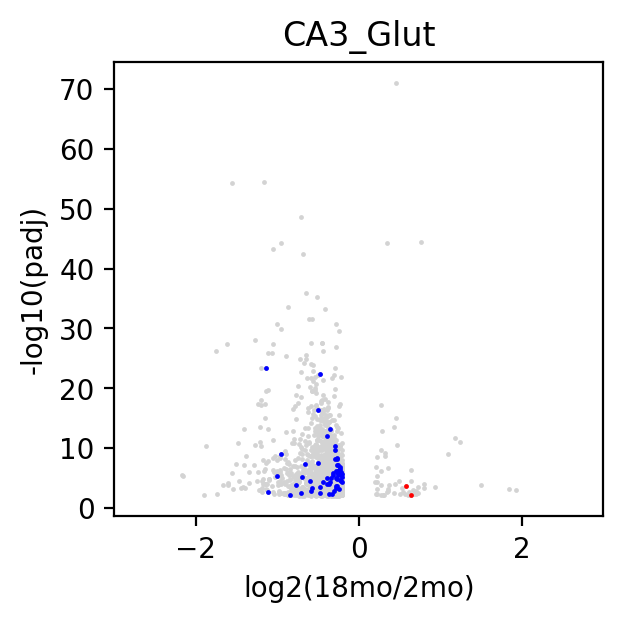

In [23]:
ncols = 1
nrows = 1

fig, ax = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True)

sns.scatterplot(data = deg_result,
                    linewidth = 0,
                    ax = ax,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'blue',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'red',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
ax.set_title(ct)
ax.set(xlim = (-3,3))

# top_genes = overlap_deg_result[(overlap_deg_result['abs_log2(18mo/2mo)'] > 0.5)]
# top_genes = top_genes.sort_values('fdr').head(10)
# for _, row in top_genes.iterrows():
#     ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
#                 textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)


In [24]:
overlap_deg_result.to_csv('DiffExpress.DomainGene.csv')